# STEP 0: Generate dummy grid data

We create dummy data for spatial grids for households. The grid data matches local data from Parish population data and distributes the population evenly according to number of adresses per grid cell.

You can change the list of municipalities, `dummy_mun_codes`, as well as and change the `dummy_compute` variable in the [config file](sqr/core/config.py). 


# Load packages

In [1]:
import os

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely

from shapely.geometry import box
from tqdm import tqdm

%matplotlib inline

# Municipality data

In [2]:
kommuner = gpd.read_file('https://dawa.aws.dk/kommuner?format=geojson')\
                .to_crs(epsg=25832)

# Parse parish data

### DST parish population

In [3]:
import requests
from io import StringIO
from copy import deepcopy

import pandas as pd

dst_api_base = 'https://api.statbank.dk/v1/data/%s/csv?'
options_base =  {'valuePresentation':'Default',
                'timeOrder':'Ascending',
                'allowVariablesInHead':'true'}

def dst_api_dataframe(dataset, options_input={}, print_url=False):    
    '''
    This function produces a dataframe for the desired 
    Statistics Denmark (DST) table. It can be specified 
    to pull particular columns.
    
    Parameters
    ----------
    dataset : str
        DST name/code table to fetch
    options_input : dict, optional
        The extra options can be speficied to pull particular
        column values. E.g. {'ABC':'*'} will return all values 
        of the column 'ABC'. Note specific column values 
        requires separation with comma_char, see example below.
        
    Returns    
    -------
    df_out : pandas.DataFrame
        Table with desired formatted as a pandas DataFrame.
    '''
    
    url = dst_api_base % dataset
    
    options = deepcopy(options_base)
    
    for k, v in options_input.items():
        options[k] = v
    
    for k, v in options.items():
        url += '%s=%s&' % (k,v) 
        
    if print_url: print(url[:-1])
        
    response = requests.get(url[:-1])
    
    df_out = pd.read_csv(StringIO(response.text), sep=';') 
    
    return df_out 
    


Fetch DST data

In [4]:
area = '*' # all parish
ages = '*'
time = [2020]

comma_char = '%2C' # separation character for making url

request_options =  {'SOGN': area, 
                    'TID': comma_char.join(map(str, time))}
    
pop = dst_api_dataframe('KM5', options_input=request_options)\
        .rename(columns={'INDHOLD':'antal_pers'})\
        .assign(kode = lambda df: df.SOGN.str[:4])

### Fetch parish shape files and merge with population

In [5]:
sogne = gpd.read_file('https://dawa.aws.dk/sogne?format=geojson')\
            .to_crs(epsg=25832)


sogne_pop = sogne.merge(pop)

# Within municipalities
Choice of municipality

In [19]:
from sqr.core.config import years_num
from sqr.core.shape import make_spatial_grid #MHG tilføjet
ymin=min(years_num) 
ymax=max(years_num)

def get_col_names(label):
    return [f'antal_{label}_{y}' for y in range(ymin, ymax+1)]

def spatial_grid_pop_households(komkode):    
    '''
    Loads address data for municipality to infer grid level
    counts of households and individuals. 
    
    Parameters
    -----------
    komkode: int
        municipal code
    '''


    ########################
    # Spatial data process #
    ########################

    # construct grid

    grid = make_spatial_grid(kommuner[kommuner.kode==f'0{komkode}'])

    # load addresses 
    # NOTE: historic addresses can be loaded using `f'http://dawa.aws.dk/historik/adresser?kommunekode={komkode}'`
    url = f'https://api.dataforsyningen.dk/adresser?kommunekode={komkode}'

    adr = pd.read_json(url)


    #############################
    # Counts by grid and parish #
    #############################

    # count addresses per square net cell
    adr_kn = adr\
        .groupby(adr.adgangsadresse.str['DDKN'].str['m100'].rename('DDKNm100'))\
        .size()\
        .rename('antal_adr')\
        .reset_index()

    # count households and individuals by parish
    sogn_adr_antal = adr.groupby(adr.adgangsadresse.str['sogn'].str['kode'].rename('kode')).size().rename('antal_adr_sogn')
    sogne_pop_kom = sogne_pop.merge(sogn_adr_antal.reset_index())    
    sogne_pop_kom['husstande_est'] = (sogne_pop_kom.antal_pers/2).round(0)
    sogne_pop_kom['husstand_per_adr'] = sogne_pop_kom['husstande_est']/sogne_pop_kom['antal_adr_sogn']
    sogne_pop_kom['pers_per_adr'] = sogne_pop_kom['antal_pers']/sogne_pop_kom['antal_adr_sogn']
    

    #######################################
    # Combine data sources to infer count #
    # of households and individuals       #
    #######################################


    grid_adr = \
        grid.merge(adr_kn,how='left')\
            .assign(antal_adr = lambda df: df.antal_adr.fillna(0))
    
    data_kom = gpd.sjoin(grid_adr, sogne_pop_kom[['geometry', 'husstand_per_adr','pers_per_adr']])\
                    .reset_index(drop=True)    
    
    # compute expected number of individuals and household per grid celles 
    count_household = (data_kom.antal_adr*data_kom.husstand_per_adr).values
    count_ind = (data_kom.antal_adr*data_kom.pers_per_adr).values

    # draw poisson numbers using expectation
    count_df = \
        pd.concat(
            [pd.DataFrame(
                data = np.random.poisson(lam=np.tile(vals.reshape(-1,1), (1,10))),
                columns = get_col_names(label)
                )
             for label, vals in [('hh', count_household), ('ind', count_ind)]
            ], axis=1, sort=False)

    output = data_kom.join(count_df)

    return output

Process data for municipalities

In [20]:
from sqr.core.config import dummy_mun_codes

os.makedirs('data/dummy/', exist_ok=True)

for komkode in tqdm(dummy_mun_codes):
    gdf = spatial_grid_pop_households(komkode)
    gdf.to_file(f'data/dummy/{komkode}.geojson', driver="GeoJSON")

100%|██████████████████████████████████████████████████████████████| 5/5 [03:48<00:00, 45.62s/it]


Construct joint data frame to fit into pipeline

In [21]:
os.makedirs('data/raw/', exist_ok=True)

raw = dict(ind=[], hh=[])
for komkode in tqdm(dummy_mun_codes):
    gdf = gpd.read_file(f'data/dummy/{komkode}.geojson')\
            .drop_duplicates(subset=['e','n'])
    for label in ('ind', 'hh'):
        col_names = get_col_names(label)
        col_map = dict(zip(col_names, list(range(ymin,ymax+1))))
        raw[label].append(
            gdf\
            .loc[:,['DDKNm100']+col_names]\
            .rename(columns=col_map)\
            .pipe(lambda df: df[df[range(ymin,ymax)].max(1)>0]))
            
pd.concat(raw['ind']).to_csv('data/raw/ind_dummy.csv',index=False)        
pd.concat(raw['hh']).to_csv('data/raw/hh_dummy.csv',index=False)        

100%|██████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.51s/it]


Sanity check: plot Frederiksberg and Bornholm

<AxesSubplot:>

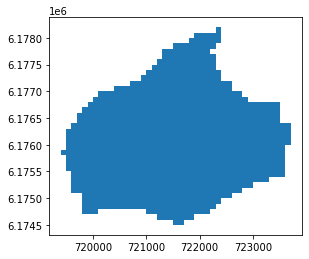

In [13]:
gpd.read_file(f'data/dummy/147.geojson').set_crs(epsg=25832,allow_override=True).plot()

Text(0.5, 1.0, 'Bornholm')

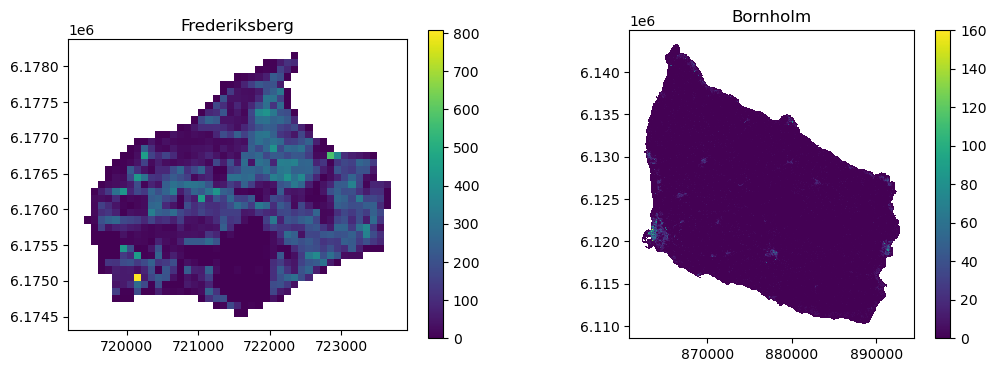

In [22]:
def plot_mun(mun_code, ax):    
    gpd.read_file(f'data/dummy/{mun_code}.geojson')\
    .drop_duplicates(subset=['e','n'])\
    .set_crs(epsg=25832,allow_override=True)\
    .plot(column='antal_ind_2019',legend=True,ax=ax)
    
f,ax = plt.subplots(1,2,figsize=(12,4))

plot_mun(147, ax[0])
plot_mun(400, ax[1])

ax[0].set_title('Frederiksberg')
ax[1].set_title('Bornholm')